# EE219 Project 2

Team members:  
Yichen Wu 504294181  
Siyuan Chen 405024391

## Required Packages:
nltk v3.2.5  
numpy v1.14.0  
scikit-learn v0.19.1  
scipy 1.0.0  
matplotlib v2.1.2  

In [27]:
import string
from sklearn.feature_extraction.text import *
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import NMF, TruncatedSVD, PCA
import nltk

from sklearn.metrics import *
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import *

from sklearn.preprocessing import Normalizer, FunctionTransformer, scale
from sklearn.pipeline import make_pipeline

'''
try:
    nltk.download("stopwords")  # if the host does not have the package
except (RuntimeError):
    pass
'''

# globals
MIN_DF = 3


class SparseToDenseArray(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, X, *_):
        if hasattr(X, 'toarray'):
            return X.toarray()
        return X

    def fit(self, *_):
        return self


tfidf_transformer = TfidfTransformer(smooth_idf=False)


def doTFIDF(data, mindf):
    vectorizer = CountVectorizer(min_df=mindf, stop_words=ENGLISH_STOP_WORDS)
    m = vectorizer.fit_transform(data)
    m_train_tfidf = tfidf_transformer.fit_transform(m)
    return m_train_tfidf


def cluster_kmean(data, n):
    km = KMeans(n_clusters=n, max_iter=100, n_init=10, verbose=False).fit(data)
    pred = km.predict(data)
    return pred


def report_stats(label, predict, classes, display=True, msg=None):
    n = len(classes)
    cmatrix = contingency_matrix(label, predict)
    if display:
        plt.imshow(cmatrix, interpolation='nearest', cmap=plt.cm.BuGn)
        plt.title("Contingency Table")
        tick_marks = np.arange(n)
        className = []
        for i in range(n):
            className.append(str(i))
        plt.xticks(tick_marks, className)
        plt.yticks(tick_marks, classes)
        fmt = 'd'
        thresh = cmatrix.max() / 2.
        for i, j in itertools.product(range(n), range(n)):
            plt.text(j, i, format(cmatrix[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if cmatrix[i, j] > thresh else "black")
        plt.tight_layout()
        plt.ylabel('Ground Truth Label')
        plt.xlabel('Cluster Label')
        plt.show()

    homogeneity = homogeneity_score(label, predict)
    completeness = completeness_score(label, predict)
    v_measure = v_measure_score(label, predict)
    adjusted_Rand_Index = adjusted_rand_score(label, predict)
    adjusted_Mutual_Info_Score = adjusted_mutual_info_score(label, predict)

    if isinstance(msg, str):
        print(msg)
    print("Homogeneity: %0.3f" % homogeneity)
    print("Completeness: %0.3f" % completeness)
    print("V-measure: %0.3f" % v_measure)
    print("Adjusted Rand-Index: %.3f" % adjusted_Rand_Index)
    print("Adjusted Mutual Info Score: %0.3f" % adjusted_Mutual_Info_Score)

    return [cmatrix, [homogeneity, completeness, v_measure, adjusted_Rand_Index, adjusted_Mutual_Info_Score]]

This part is to load data and import the library that we need for this project.

In [15]:
import numpy as np
import logging
import os
import pickle
from logging.config import fileConfig
from sklearn.datasets import fetch_20newsgroups

# create logger
fileConfig('logging_config.ini')
logger = logging.getLogger()
logger.setLevel("WARNING")
# logger.setLevel("INFO")

categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware',
              'comp.sys.mac.hardware', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']

cat_comp = categories[:4]   # Computer Technologies
cat_rec = categories[4:]    # Recreational Activities
CAT = ["Computer Technologies", "Recreational Activities"]

logging.info("loading data")
all_data = fetch_20newsgroups(subset='all', shuffle=True, random_state=42)
train_data = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
test_data = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

# create labels
# 0 for computer technology, 1 for recreational activities
all_label = all_data.target
train_label = [(x//4) for x in train_data.target]
test_label = [(x//4) for x in test_data.target]

CAT_ALL = all_data.target_names

logging.info("loading finished")

#### a)

In [40]:
from timeit import default_timer as timer

GET_DATA_FROM_FILES = True
DETAILS = False

logging.info("Problem 1")
start = timer()

X_train_tfidf = None
if GET_DATA_FROM_FILES and os.path.isfile("./train_tfidf.pkl"):
    logging.info("Loading tfidf vector.")
    X_train_tfidf = pickle.load(open("./train_tfidf.pkl", "rb"))
else:
    X_train_tfidf = doTFIDF(train_data.data, MIN_DF)
    pickle.dump(X_train_tfidf, open("./train_tfidf.pkl", "wb"))

print("With min_df = %d , (training documents, terms extracted): " % MIN_DF, X_train_tfidf.shape)

duration = timer() - start
logging.debug("Computation Time in secs: %d" % duration)
logging.info("finished Problem 1")

With min_df = 3 , (training documents, terms extracted):  (4732, 20297)


#### b)

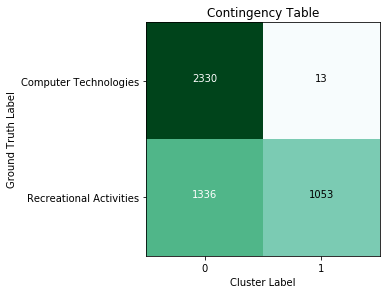

Homogeneity: 0.245
Completeness: 0.319
V-measure: 0.277
Adjusted Rand-Index: 0.185
Adjusted Mutual Info Score: 0.245


In [28]:
logging.info("Problem 2")
start = timer()

km_pred = None
if GET_DATA_FROM_FILES and os.path.isfile("./kmean.pkl"):
    logging.info("Loading predicted kmean.")
    km_pred = pickle.load(open("./kmean.pkl", "rb"))
else:
    km_pred = cluster_kmean(X_train_tfidf, 2)
    pickle.dump(km_pred, open("./kmean.pkl", "wb"))

report_stats(train_label, km_pred, CAT)

duration = timer() - start
logging.debug("Computation Time in secs: %d" % duration)
logging.info("finished Problem 2")

#### c) - 1

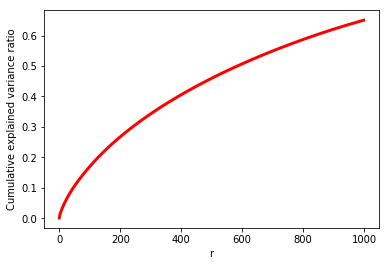

In [18]:
logging.info("Problem 3")
start = timer()

R_MAX = 1000
ratio = None
if GET_DATA_FROM_FILES and os.path.isfile("./ratio.pkl"):
    logging.info("Loading ratio.")
    ratio = pickle.load(open("./ratio.pkl", "rb"))
else:
    svd = TruncatedSVD(n_components=R_MAX, n_iter=7)
    svd.fit_transform(X_train_tfidf)
    ratio = svd.explained_variance_ratio_.cumsum()
    pickle.dump(ratio, open("./ratio.pkl", "wb"), True)

plt.plot(range(R_MAX), ratio, 'r', lw=3, label='Cumulative explained variance ratio')
plt.ylabel('Cumulative explained variance ratio')
plt.xlabel('r')
plt.show()

#### c) - 2

With r = 1 Using LSI
Homogeneity: 0.000
Completeness: 0.000
V-measure: 0.000
Adjusted Rand-Index: -0.000
Adjusted Mutual Info Score: -0.000
-  -  -  -  -  -  -  -  -  -  
The contingency matrix is: 
[[1051 1292]
 [1046 1343]]
------------------------------
With r = 2 Using LSI
Homogeneity: 0.511
Completeness: 0.526
V-measure: 0.518
Adjusted Rand-Index: 0.562
Adjusted Mutual Info Score: 0.510
-  -  -  -  -  -  -  -  -  -  
The contingency matrix is: 
[[  45 2298]
 [1842  547]]
------------------------------
With r = 3 Using LSI
Homogeneity: 0.258
Completeness: 0.337
V-measure: 0.292
Adjusted Rand-Index: 0.189
Adjusted Mutual Info Score: 0.258
-  -  -  -  -  -  -  -  -  -  
The contingency matrix is: 
[[   4 2339]
 [1055 1334]]
------------------------------
With r = 5 Using LSI
Homogeneity: 0.227
Completeness: 0.316
V-measure: 0.264
Adjusted Rand-Index: 0.147
Adjusted Mutual Info Score: 0.227
-  -  -  -  -  -  -  -  -  -  
The contingency matrix is: 
[[   1 2342]
 [ 933 1456]]
---------

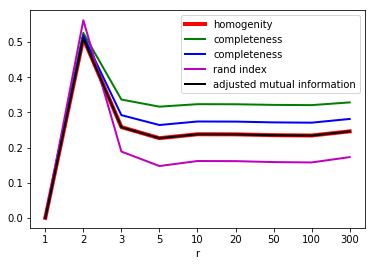

************************************************************
The best R value for TruncatedSVD is 2
The contingency matrix is: 
[[  45 2298]
 [1842  547]]
Homogeneity: 0.511
Completeness: 0.526
V-measure: 0.518
Adjusted Rand-Index: 0.562
Adjusted Mutual Info Score: 0.510
************************************************************


In [29]:
r = [1, 2, 3, 5, 10, 20, 50, 100, 300]

# LSI
y_lsi = None
cmatrix_lsi = None
if GET_DATA_FROM_FILES and not DETAILS \
        and os.path.isfile("./y_lsi.pkl") \
        and os.path.isfile("./cmatrix_lsi.pkl"):
    logging.info("Loading y and cmatrix for LSI.")
    y_lsi = pickle.load(open("./y_lsi.pkl", "rb"))
    cmatrix_lsi = pickle.load(open("./cmatrix_lsi.pkl", "rb"))
else:
    y_lsi = []
    cmatrix_lsi = []
    for i in r:
        svd = TruncatedSVD(n_components=i, random_state=None)
        # normalizer = Normalizer(copy=False)
        # pipeline = make_pipeline(svd, normalizer)
        # X_train_lsi = pipeline.fit_transform(X_train_tfidf)
        X_train_lsi = svd.fit_transform(X_train_tfidf)
        kmean = cluster_kmean(X_train_lsi, 2)
        msg = 'With r = %d' % i + " Using LSI"
        result = report_stats(train_label, kmean, CAT, display=False, msg=msg)
        print("-  "*10)
        print("The contingency matrix is: ")
        cmatrix_lsi.append(result[0])
        print(result[0])
        y_lsi.append(result[1])
        print("-"*30)

    pickle.dump(y_lsi, open("./y_lsi.pkl", "wb"), True)
    pickle.dump(cmatrix_lsi, open("./cmatrix_lsi.pkl", "wb"), True)

y_transpose = np.array(y_lsi).T.tolist()

r_len = len(r)
l1, = plt.plot(range(r_len), y_transpose[0], 'r', lw=4, label='homogenity')
l2, = plt.plot(range(r_len), y_transpose[1], 'g', lw=2, label='completeness')
l3, = plt.plot(range(r_len), y_transpose[2], 'b', lw=2, label='completeness')
l4, = plt.plot(range(r_len), y_transpose[3], 'm', lw=2, label='rand index')
l5, = plt.plot(range(r_len), y_transpose[4], 'k', lw=2, label='adjusted mutual information')
tick_marks = np.arange(r_len)
labels = [str(a) for a in r]
plt.xticks(tick_marks, labels)
plt.legend(handles=[l1, l2, l3, l4, l5])
plt.xlabel('r')
plt.show()

best_r = [np.argmax(y_transpose[i]) for i in range(5)]
print("*"*60)
bi_lsi = np.bincount(best_r).argmax() # best_r_index
print("The best R value for TruncatedSVD is %d" % r[bi_lsi])
print("The contingency matrix is: ")
print(cmatrix_lsi[bi_lsi])
print("Homogeneity: %0.3f" % y_transpose[0][bi_lsi])
print("Completeness: %0.3f" % y_transpose[1][bi_lsi])
print("V-measure: %0.3f" % y_transpose[2][bi_lsi])
print("Adjusted Rand-Index: %.3f" % y_transpose[3][bi_lsi])
print("Adjusted Mutual Info Score: %0.3f" % y_transpose[4][bi_lsi])
print("*"*60)

**Note:** the result(best R value) is random and unrepeatable with different random_state! (Need luck to get to global minimum for each R.)

#### c) - 3

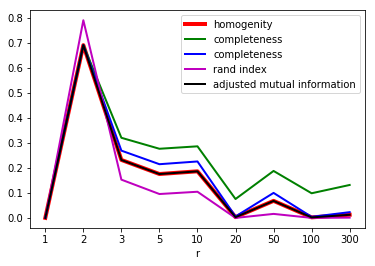

************************************************************
The best R value for NMF is 2
The contingency matrix is: 
[[2224  119]
 [ 145 2244]]
Homogeneity: 0.690
Completeness: 0.690
V-measure: 0.690
Adjusted Rand-Index: 0.789
Adjusted Mutual Info Score: 0.690
************************************************************


In [30]:
# NMF
# if GET_DATA_FROM_FILES and not DETAILS \
if os.path.isfile("./y_nmf.pkl") \
        and os.path.isfile("./cmatrix_nmf.pkl"):
    logging.info("Loading y and cmatrix for NMF.")
    y_nmf = pickle.load(open("./y_nmf.pkl", "rb"))
    cmatrix_nmf = pickle.load(open("./cmatrix_nmf.pkl", "rb"))
else:
    y_nmf = []
    cmatrix_nmf = []
    for i in r:
        nmf = NMF(n_components=i)
        # normalizer = Normalizer(copy=False)
        # pipeline = make_pipeline(svd, normalizer)
        # X_train_lsi = pipeline.fit_transform(X_train_tfidf)
        X_train_nmf = nmf.fit_transform(X_train_tfidf)
        kmean = cluster_kmean(X_train_nmf, 2)
        msg = 'With r = %d' % i + " Using NMF"
        result = report_stats(train_label, kmean, CAT, display=False, msg=msg)
        print("-  "*10)
        print("The contingency matrix is: ")
        cmatrix_nmf.append(result[0])
        print(result[0])
        y_nmf.append(result[1])
        print("-"*30)
    pickle.dump(y_nmf, open("./y_nmf.pkl", "wb"), True)
    pickle.dump(cmatrix_nmf, open("./cmatrix_nmf.pkl", "wb"), True)

y_transpose = np.array(y_nmf).T.tolist()

r_len = len(r)
l1, = plt.plot(range(r_len), y_transpose[0], 'r', lw=4, label='homogenity')
l2, = plt.plot(range(r_len), y_transpose[1], 'g', lw=2, label='completeness')
l3, = plt.plot(range(r_len), y_transpose[2], 'b', lw=2, label='completeness')
l4, = plt.plot(range(r_len), y_transpose[3], 'm', lw=2, label='rand index')
l5, = plt.plot(range(r_len), y_transpose[4], 'k', lw=2, label='adjusted mutual information')
tick_marks = np.arange(r_len)
labels = [str(a) for a in r]
plt.xticks(tick_marks, labels)
plt.legend(handles=[l1, l2, l3, l4, l5])
plt.xlabel('r')
plt.show()

best_r = [np.argmax(y_transpose[i]) for i in range(5)]
print("*"*60)
bi_nmf = np.bincount(best_r).argmax() # best_r_index
print("The best R value for NMF is %d" % r[bi_nmf])
print("The contingency matrix is: ")
print(cmatrix_nmf[bi_nmf])
print("Homogeneity: %0.3f" % y_transpose[0][bi_nmf])
print("Completeness: %0.3f" % y_transpose[1][bi_nmf])
print("V-measure: %0.3f" % y_transpose[2][bi_nmf])
print("Adjusted Rand-Index: %.3f" % y_transpose[3][bi_nmf])
print("Adjusted Mutual Info Score: %0.3f" % y_transpose[4][bi_nmf])
print("*"*60)

duration = timer() - start
logging.debug("Computation Time in secs: %d" % duration)
logging.info("finished Problem 3")

#### d) 

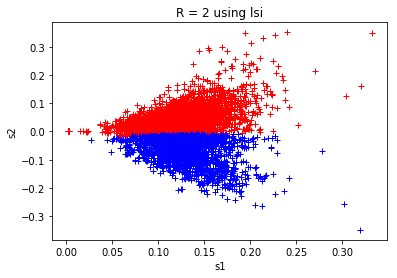

R = 2 using lsi
Homogeneity: 0.516
Completeness: 0.531
V-measure: 0.523
Adjusted Rand-Index: 0.572
Adjusted Mutual Info Score: 0.516
-  -  -  -  -  -  -  -  -  -  
The contingency matrix is: 
[[2294   49]
 [ 527 1862]]


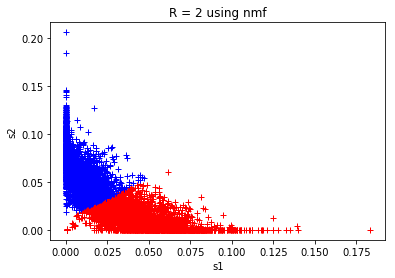

R = 2 using nmf
Homogeneity: 0.691
Completeness: 0.691
V-measure: 0.691
Adjusted Rand-Index: 0.790
Adjusted Mutual Info Score: 0.691
-  -  -  -  -  -  -  -  -  -  
The contingency matrix is: 
[[2224  119]
 [ 144 2245]]


In [31]:
logging.info("Problem 4")
start = timer()

# plot best LSI and NMF result

def plot_cluster_2D(r, reduct_method, norm=False, log_bf=False, log_af=False, report_stat=False):
    if r < 2:
        logging.warning("Cannot plot. Dimension smaller than 2.")
        return
    
    reduct = None
    if reduct_method is 'lsi':
        if log_bf or log_af:
            logging.warning("Cannot apply log to lsi.")
            return
        reduct = TruncatedSVD(n_components=r, random_state=None)
    elif reduct_method is 'nmf':
        reduct = NMF(n_components=r)
    else:
        logging.warning("Cannot plot. Unknown dimensionality reduction method.")
        return
    
    X_train_svd = None
    if norm:
        if log_bf:
            log_trans_bf = FunctionTransformer(np.log1p)
            pipeline = make_pipeline(reduct, log_trans_bf)
            X_train_not_norm = pipeline.fit_transform(X_train_tfidf)
        else:
            X_train_not_norm = reduct.fit_transform(X_train_tfidf)
            
        X_train_svd = scale(X_train_not_norm) 
    else:
        X_train_svd = reduct.fit_transform(X_train_tfidf)
    
    X_train_km = None
    if log_af:
        log_trans_af = FunctionTransformer(np.log1p)
        matrix_min = np.amin(X_train_svd)
        X_train_km = np.nan_to_num(log_trans_af.fit_transform(X_train_svd-matrix_min))
    else:
        X_train_km = X_train_svd
        
    kmeans = cluster_kmean(X_train_km, 2)
    
    x1 = X_train_km[kmeans == 0][:, 0]
    y1 = X_train_km[kmeans == 0][:, 1]
    x2 = X_train_km[kmeans == 1][:, 0]
    y2 = X_train_km[kmeans == 1][:, 1]
    
    plt.plot(x1, y1, 'r+')
    plt.plot(x2, y2, 'b+')
    title = "R = %d using " % r + reduct_method \
            + (" and logarithmic transformation" if log_bf else '')\
            + (" and normalization" if norm else '') \
            + (" and logarithmic transformation" if log_af else '')
    plt.title(title)
    plt.xlabel('s1')
    plt.ylabel('s2')
    plt.show()
    
    if report_stat:
        result = report_stats(train_label, kmeans, CAT, display=False, msg=title)
        print("-  "*10)
        print("The contingency matrix is: ")
        print(result[0])
        
    
plot_cluster_2D(r[bi_lsi], reduct_method='lsi', report_stat=True)
plot_cluster_2D(r[bi_nmf], reduct_method='nmf', report_stat=True)

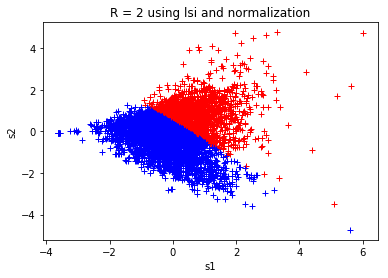

R = 2 using lsi and normalization
Homogeneity: 0.196
Completeness: 0.218
V-measure: 0.206
Adjusted Rand-Index: 0.220
Adjusted Mutual Info Score: 0.196
-  -  -  -  -  -  -  -  -  -  
The contingency matrix is: 
[[1293 1050]
 [ 205 2184]]


In [32]:
plot_cluster_2D(r[bi_lsi], reduct_method='lsi', norm=True, report_stat=True)

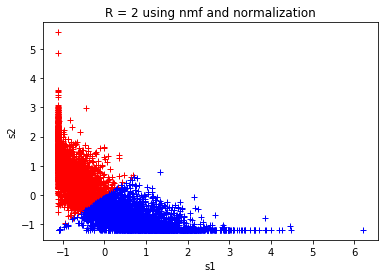

R = 2 using nmf and normalization
Homogeneity: 0.711
Completeness: 0.712
V-measure: 0.711
Adjusted Rand-Index: 0.807
Adjusted Mutual Info Score: 0.711
-  -  -  -  -  -  -  -  -  -  
The contingency matrix is: 
[[ 148 2195]
 [2296   93]]


In [33]:
plot_cluster_2D(r[bi_nmf], reduct_method='nmf', norm=True, report_stat=True)

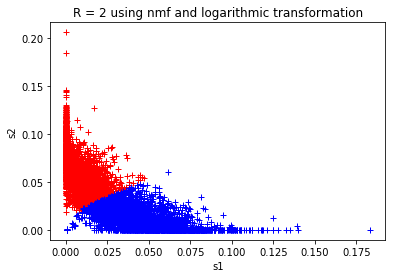

R = 2 using nmf and logarithmic transformation
Homogeneity: 0.691
Completeness: 0.691
V-measure: 0.691
Adjusted Rand-Index: 0.790
Adjusted Mutual Info Score: 0.691
-  -  -  -  -  -  -  -  -  -  
The contingency matrix is: 
[[ 119 2224]
 [2245  144]]


In [34]:
plot_cluster_2D(r[bi_nmf], reduct_method='nmf', log_bf=True, report_stat=True)

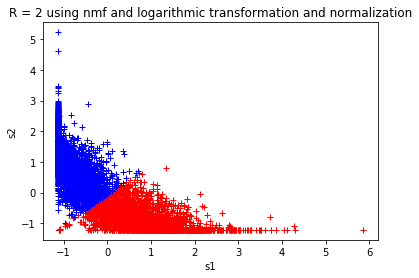

R = 2 using nmf and logarithmic transformation and normalization
Homogeneity: 0.709
Completeness: 0.710
V-measure: 0.710
Adjusted Rand-Index: 0.805
Adjusted Mutual Info Score: 0.709
-  -  -  -  -  -  -  -  -  -  
The contingency matrix is: 
[[2193  150]
 [  93 2296]]


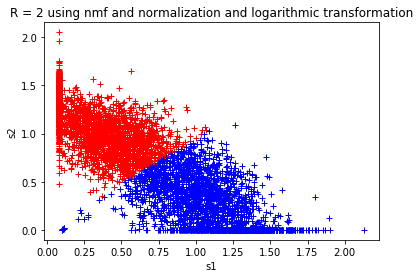

R = 2 using nmf and normalization and logarithmic transformation
Homogeneity: 0.708
Completeness: 0.708
V-measure: 0.708
Adjusted Rand-Index: 0.803
Adjusted Mutual Info Score: 0.708
-  -  -  -  -  -  -  -  -  -  
The contingency matrix is: 
[[ 158 2185]
 [2301   88]]


In [25]:
plot_cluster_2D(r[bi_nmf], reduct_method='nmf', norm=True, log_bf=True, report_stat=True)
plot_cluster_2D(r[bi_nmf], reduct_method='nmf', norm=True, log_af=True, report_stat=True)

#### e) 

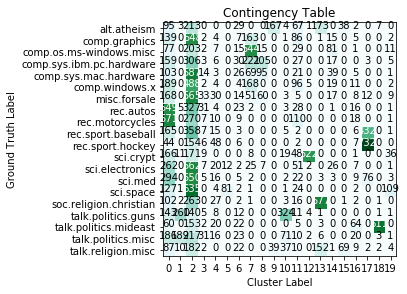

Without dimensionality reduction
Homogeneity: 0.281
Completeness: 0.382
V-measure: 0.324
Adjusted Rand-Index: 0.081
Adjusted Mutual Info Score: 0.279


In [35]:
# Without preprocessing

X_all_tfidf = None
if GET_DATA_FROM_FILES and os.path.isfile("./all_tfidf.pkl"):
    logging.info("Loading tfidf vector.")
    X_all_tfidf = pickle.load(open("./all_tfidf.pkl", "rb"))
else:
    X_all_tfidf = doTFIDF(all_data.data, MIN_DF)
    pickle.dump(X_train_tfidf, open("./all_tfidf.pkl", "wb"))
    
kmeans = cluster_kmean(X_all_tfidf, 20)
result = report_stats(all_label, kmeans, CAT_ALL, display=True, msg="Without dimensionality reduction")

With r = 1 Using LSI
Homogeneity: 0.028
Completeness: 0.031
V-measure: 0.029
Adjusted Rand-Index: 0.006
Adjusted Mutual Info Score: 0.025
------------------------------
With r = 2 Using LSI
Homogeneity: 0.210
Completeness: 0.226
V-measure: 0.217
Adjusted Rand-Index: 0.065
Adjusted Mutual Info Score: 0.207
------------------------------
With r = 3 Using LSI
Homogeneity: 0.237
Completeness: 0.247
V-measure: 0.242
Adjusted Rand-Index: 0.082
Adjusted Mutual Info Score: 0.234
------------------------------
With r = 5 Using LSI
Homogeneity: 0.315
Completeness: 0.334
V-measure: 0.324
Adjusted Rand-Index: 0.125
Adjusted Mutual Info Score: 0.313
------------------------------
With r = 10 Using LSI
Homogeneity: 0.329
Completeness: 0.385
V-measure: 0.355
Adjusted Rand-Index: 0.132
Adjusted Mutual Info Score: 0.327
------------------------------
With r = 20 Using LSI
Homogeneity: 0.285
Completeness: 0.379
V-measure: 0.326
Adjusted Rand-Index: 0.091
Adjusted Mutual Info Score: 0.283
---------------

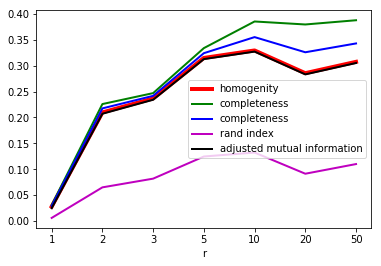

************************************************************
The best R value for TruncatedSVD is 10
Homogeneity: 0.329
Completeness: 0.385
V-measure: 0.355
Adjusted Rand-Index: 0.132
Adjusted Mutual Info Score: 0.327
************************************************************


In [38]:
r2 = [1, 2, 3, 5, 10, 20, 50]

# LSI
y_lsi_all = None
cmatrix_lsi_all = None
if GET_DATA_FROM_FILES and not DETAILS \
        and os.path.isfile("./y_lsi_all.pkl") \
        and os.path.isfile("./cmatrix_lsi_all.pkl"):
    logging.info("Loading y_all and cmatrix_all for LSI.")
    y_lsi_all = pickle.load(open("./y_lsi_all.pkl", "rb"))
    cmatrix_lsi_all = pickle.load(open("./cmatrix_lsi_all.pkl", "rb"))
else:
    y_lsi_all = []
    cmatrix_lsi_all = []
    for i in r2:
        svd = TruncatedSVD(n_components=i, random_state=None)
        X_all_lsi = svd.fit_transform(X_all_tfidf)
        kmean = cluster_kmean(X_all_lsi, 20)
        msg = 'With r = %d' % i + " Using LSI"
        result = report_stats(all_label, kmean, CAT_ALL, display=False, msg=msg)
#        print("-  "*10)
#        print("The contingency matrix is: ")
        cmatrix_lsi_all.append(result[0])
#        print(result[0])
        y_lsi_all.append(result[1])
        print("-"*30)

    pickle.dump(y_lsi_all, open("./y_lsi.pkl", "wb"), True)
    pickle.dump(cmatrix_lsi_all, open("./cmatrix_lsi.pkl", "wb"), True)

y_transpose = np.array(y_lsi_all).T.tolist()

r2_len = len(r2)
l1, = plt.plot(range(r2_len), y_transpose[0], 'r', lw=4, label='homogenity')
l2, = plt.plot(range(r2_len), y_transpose[1], 'g', lw=2, label='completeness')
l3, = plt.plot(range(r2_len), y_transpose[2], 'b', lw=2, label='completeness')
l4, = plt.plot(range(r2_len), y_transpose[3], 'm', lw=2, label='rand index')
l5, = plt.plot(range(r2_len), y_transpose[4], 'k', lw=2, label='adjusted mutual information')
tick_marks = np.arange(r2_len)
labels = [str(a) for a in r2]
plt.xticks(tick_marks, labels)
plt.legend(handles=[l1, l2, l3, l4, l5])
plt.xlabel('r')
plt.show()

best_r2 = [np.argmax(y_transpose[i]) for i in range(5)]
print("*"*60)
bi_lsi_all = np.bincount(best_r2).argmax() # best_r_index
print("The best R value for TruncatedSVD is %d" % r[bi_lsi_all])
# print("The contingency matrix is: ")
# print(cmatrix_lsi_all[bi_lsi_all])
print("Homogeneity: %0.3f" % y_transpose[0][bi_lsi_all])
print("Completeness: %0.3f" % y_transpose[1][bi_lsi_all])
print("V-measure: %0.3f" % y_transpose[2][bi_lsi_all])
print("Adjusted Rand-Index: %.3f" % y_transpose[3][bi_lsi_all])
print("Adjusted Mutual Info Score: %0.3f" % y_transpose[4][bi_lsi_all])
print("*"*60)

With r = 1 Using NMF
Homogeneity: 0.028
Completeness: 0.031
V-measure: 0.030
Adjusted Rand-Index: 0.006
Adjusted Mutual Info Score: 0.025
------------------------------
With r = 2 Using NMF
Homogeneity: 0.169
Completeness: 0.181
V-measure: 0.175
Adjusted Rand-Index: 0.051
Adjusted Mutual Info Score: 0.166
------------------------------
With r = 3 Using NMF
Homogeneity: 0.192
Completeness: 0.210
V-measure: 0.201
Adjusted Rand-Index: 0.058
Adjusted Mutual Info Score: 0.189
------------------------------
With r = 5 Using NMF
Homogeneity: 0.292
Completeness: 0.308
V-measure: 0.300
Adjusted Rand-Index: 0.103
Adjusted Mutual Info Score: 0.289
------------------------------
With r = 10 Using NMF
Homogeneity: 0.317
Completeness: 0.357
V-measure: 0.336
Adjusted Rand-Index: 0.124
Adjusted Mutual Info Score: 0.315
------------------------------
With r = 20 Using NMF
Homogeneity: 0.275
Completeness: 0.390
V-measure: 0.323
Adjusted Rand-Index: 0.072
Adjusted Mutual Info Score: 0.273
---------------

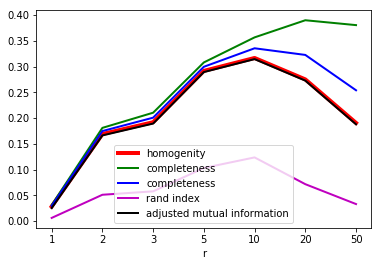

************************************************************
The best R value for NMF is 10
Homogeneity: 0.317
Completeness: 0.357
V-measure: 0.336
Adjusted Rand-Index: 0.124
Adjusted Mutual Info Score: 0.315
************************************************************


In [39]:
# NMF
y_nmf_all = None
cmatrix_nmf_all = None
if GET_DATA_FROM_FILES and not DETAILS \
        and os.path.isfile("./y_nmf_all.pkl") \
        and os.path.isfile("./cmatrix_nmf_all.pkl"):
    logging.info("Loading y_all and cmatrix_all for NMF.")
    y_nmf_all = pickle.load(open("./y_nmf_all.pkl", "rb"))
    cmatrix_nmf_all = pickle.load(open("./cmatrix_nmf_all.pkl", "rb"))
else:
    y_nmf_all = []
    cmatrix_nmf_all = []
    for i in r2:
        svd = NMF(n_components=i)
        X_all_nmf = svd.fit_transform(X_all_tfidf)
        kmean = cluster_kmean(X_all_nmf, 20)
        msg = 'With r = %d' % i + " Using NMF"
        result = report_stats(all_label, kmean, CAT_ALL, display=False, msg=msg)
#        print("-  "*10)
#        print("The contingency matrix is: ")
        cmatrix_nmf_all.append(result[0])
#        print(result[0])
        y_nmf_all.append(result[1])
        print("-"*30)

    pickle.dump(y_nmf_all, open("./y_nmf_all.pkl", "wb"), True)
    pickle.dump(cmatrix_nmf_all, open("./cmatrix_nmf_all.pkl", "wb"), True)

y_transpose = np.array(y_nmf_all).T.tolist()

r2_len = len(r2)
l1, = plt.plot(range(r2_len), y_transpose[0], 'r', lw=4, label='homogenity')
l2, = plt.plot(range(r2_len), y_transpose[1], 'g', lw=2, label='completeness')
l3, = plt.plot(range(r2_len), y_transpose[2], 'b', lw=2, label='completeness')
l4, = plt.plot(range(r2_len), y_transpose[3], 'm', lw=2, label='rand index')
l5, = plt.plot(range(r2_len), y_transpose[4], 'k', lw=2, label='adjusted mutual information')
tick_marks = np.arange(r2_len)
labels = [str(a) for a in r2]
plt.xticks(tick_marks, labels)
plt.legend(handles=[l1, l2, l3, l4, l5])
plt.xlabel('r')
plt.show()

best_r2 = [np.argmax(y_transpose[i]) for i in range(5)]
print("*"*60)
bi_nmf_all = np.bincount(best_r2).argmax() # best_r_index
print("The best R value for NMF is %d" % r[bi_nmf_all])
# print("The contingency matrix is: ")
# print(cmatrix_nmf_all[bi_nmf_all])
print("Homogeneity: %0.3f" % y_transpose[0][bi_nmf_all])
print("Completeness: %0.3f" % y_transpose[1][bi_nmf_all])
print("V-measure: %0.3f" % y_transpose[2][bi_nmf_all])
print("Adjusted Rand-Index: %.3f" % y_transpose[3][bi_nmf_all])
print("Adjusted Mutual Info Score: %0.3f" % y_transpose[4][bi_nmf_all])
print("*"*60)

In [45]:
def try_other_transform(r, reduct_method, norm=False, log_bf=False, log_af=False, report_stat=False):
    if r < 2:
        logging.warning("Cannot plot. Dimension smaller than 2.")
        return
    
    reduct = None
    if reduct_method is 'lsi':
        if log_bf or log_af:
            logging.warning("Cannot apply log to lsi.")
            return
        reduct = TruncatedSVD(n_components=r, random_state=None)
    elif reduct_method is 'nmf':
        reduct = NMF(n_components=r)
    else:
        logging.warning("Cannot plot. Unknown dimensionality reduction method.")
        return
        
    X_all_svd = None
    if norm:
        if log_bf:
            log_trans_bf = FunctionTransformer(np.log1p)
            pipeline = make_pipeline(reduct, log_trans_bf)
            X_all_not_norm = pipeline.fit_transform(X_all_tfidf)
        else:
            X_all_not_norm = reduct.fit_transform(X_all_tfidf)
            
        X_all_svd = scale(X_all_not_norm) 
    else:
        X_all_svd = reduct.fit_transform(X_all_tfidf)
    
    X_all_km = None
    if log_af:
        log_trans_af = FunctionTransformer(np.log1p)
        matrix_min = np.amin(X_all_svd)
        X_all_km = np.nan_to_num(log_trans_af.fit_transform(X_all_svd - matrix_min))
    else:
        X_all_km = X_all_svd
        
    kmeans = cluster_kmean(X_all_km, 20)
    title = "R = %d using " % r + reduct_method \
        + (" and logarithmic transformation" if log_bf else '')\
        + (" and normalization" if norm else '') \
        + (" and logarithmic transformation" if log_af else '')
        
    if report_stat:
        result = report_stats(all_label, kmeans, CAT_ALL, display=False, msg=title)
        print('-'*60)
#        print("-  "*10)
#        print("The contingency matrix is: ")
#        print(result[0])
        
    

In [47]:
try_other_transform(r2[bi_lsi_all], reduct_method='lsi', report_stat=True)
try_other_transform(r2[bi_nmf_all], reduct_method='nmf', report_stat=True)
try_other_transform(r2[bi_lsi_all], reduct_method='lsi', norm=True, report_stat=True)
try_other_transform(r2[bi_nmf_all], reduct_method='nmf', norm=True, report_stat=True)
try_other_transform(r2[bi_nmf_all], reduct_method='nmf', log_bf=True, report_stat=True)
try_other_transform(r2[bi_nmf_all], reduct_method='nmf', norm=True, log_bf=True, report_stat=True)
try_other_transform(r2[bi_nmf_all], reduct_method='nmf', norm=True, log_af=True, report_stat=True)

R = 10 using lsi
Homogeneity: 0.333
Completeness: 0.375
V-measure: 0.353
Adjusted Rand-Index: 0.133
Adjusted Mutual Info Score: 0.331
------------------------------------------------------------
R = 10 using nmf
Homogeneity: 0.316
Completeness: 0.356
V-measure: 0.335
Adjusted Rand-Index: 0.123
Adjusted Mutual Info Score: 0.314
------------------------------------------------------------
R = 10 using lsi and normalization
Homogeneity: 0.311
Completeness: 0.350
V-measure: 0.329
Adjusted Rand-Index: 0.127
Adjusted Mutual Info Score: 0.309
------------------------------------------------------------
R = 10 using nmf and normalization
Homogeneity: 0.301
Completeness: 0.337
V-measure: 0.318
Adjusted Rand-Index: 0.118
Adjusted Mutual Info Score: 0.299
------------------------------------------------------------
R = 10 using nmf and logarithmic transformation
Homogeneity: 0.315
Completeness: 0.355
V-measure: 0.334
Adjusted Rand-Index: 0.123
Adjusted Mutual Info Score: 0.313
-------------------